In [230]:
import pandas as pd
import numpy as np
import os 
import datetime 
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', 100, 'display.max_rows', 100, 'display.max_colwidth', True)
%matplotlib inline
# get directory address
path= "/Users/waleedidrees/Dropbox/Python_Projects/My_Projects/Quantitative Analyst 2021/"
path

'/Users/waleedidrees/Dropbox/Python_Projects/My_Projects/Quantitative Analyst 2021/'

# Intorudction
* In this analysis we make a model to predict outcome of Footbal matches.
* df_Odds data has odds for the games for firt and season, we can use odds either directly in model or 
* We can make a model and use odds with predicted probabilities as weighted average.
* the players name and position id is provided in df_players and what teams they play for.
* df_starting we have the information of starting 11 for each match and team.
* df_results has infol about hometeam, awayteam, home and away scores and shots, 
* and df_teams has the data of names of the teams 

# Methodology:
* The analysis starts by loading the data and performing an exploratory data analysis (EDA).
* During the EDA, several questions were explored, such as finding out which team won, lost or had a draw by goal difference and points.
* The data was wrangled, and a cumulative sum of goals and points were created for each team for each season. 
* Correlations between the number of shots and goals were explored, and it was observed that teams score more goals consistently when playing at home.

## Load Data

In [231]:
df_odds=pd.read_csv(path+"odds.csv").rename(columns= lambda df_: str.lower(df_))            
df_players= pd.read_csv(path+"players.csv").rename(columns= lambda df_: str.lower(df_))            
df_results=pd.read_csv(path+"results.csv").rename(columns= lambda df_: str.lower(df_))            
df_starting= pd.read_csv(path+"startingXI.csv", sep = "," ).rename(columns= lambda df_: str.lower(df_))            
df_startingXI = pd.concat([df_starting.filter(["matchid"]),  df_starting.startingxi.str.split( ",",  expand = True)], axis=1)
df_teams=pd.read_csv(path+"teams.csv").rename(columns= lambda df_: str.lower(df_))            
df_results.head(3)

,seasonid,gameweek,matchid,hometeamid,homescore,homeshots,awayteamid,awayscore,awayshots
0,1,1,1,7,1,17,1,1,12
1,1,1,2,6,1,8,8,3,17
2,1,1,3,5,5,21,9,1,7


### Check for null values and columns types.
* there are no empty values and all columns in df_teams is integer.

In [232]:
df_results.isna().sum().to_frame().T

,seasonid,gameweek,matchid,hometeamid,homescore,homeshots,awayteamid,awayscore,awayshots
0,0,0,0,0,0,0,0,0,0


* Both Season have 756 matches played

In [233]:
df_results.seasonid.value_counts()

1    756
2    756
Name: seasonid, dtype: int64

In [234]:
pd.DataFrame(df_results.dtypes).T

,seasonid,gameweek,matchid,hometeamid,homescore,homeshots,awayteamid,awayscore,awayshots
0,int64,int64,int64,int64,int64,int64,int64,int64,int64


## EDA
We will perform EDA analysis and look and explore following questions:
* Find out by goal difference which team won, lose or had a draw
* each team playes away and home matches and there are 28 team which means each team will play in total 56 matches each
* Combine home and away matches in one column by converting data to long format and add a dummy 1 for home and 0 for away
* what was the biggest upset of the match.
* team column present all teams playing at home ground and opponent are all teams when playing away games

### Data wrangle for EDA
* find out by goal difference and which team won, lose or had a draw and points.

In [235]:
def seasons_data(season):
    # find out by goal difference which team won, lose or had a draw
        df_season=(
            df_results
            .rename(columns= lambda df_: str.lower(df_))            
            #.query('seasonid == 1 & hometeamid.isin([1,2]) & awayteamid.isin([1,2])')
            .sort_values("awayteamid", ascending= False)  
            .assign( goal_margin = lambda df_: df_.homescore - df_.awayscore,
                        target = lambda df_:  np.where( df_.goal_margin <0, "away_win",
                                                            np.where( df_.goal_margin >0, "home_win", "draw")
                                                            ),
                        home_win_points = lambda df_ : np.where ( df_.target.isin(["home_win"]), 3, 
                                                                    np.where(df_.target.isin(["away_win"]), 0, 1
                                                                            ) ),
                        away_win_points = lambda df_ : np.where ( df_.target.isin(["away_win"]), 3,
                                                                    np.where(df_.target.isin(["home_win"]), 0, 1 
                                                                            )
                                                                    )
        )
        .query('seasonid == @season')   
        )
        return df_season
df_ml= list(map(seasons_data, df_results.seasonid.unique() ))

In [236]:
df_ml= {"s1": df_ml[0], "s2": df_ml[1] }
df_ml["s1"].head()

,seasonid,gameweek,matchid,hometeamid,homescore,homeshots,awayteamid,awayscore,awayshots,goal_margin,target,home_win_points,away_win_points
74,1,6,75,9,0,10,28,1,11,-1,away_win,0,3
422,1,31,423,24,1,16,28,1,7,0,draw,1,1
414,1,30,415,12,2,9,28,2,9,0,draw,1,1
671,1,48,672,27,2,16,28,3,8,-1,away_win,0,3
687,1,50,688,26,4,15,28,4,21,0,draw,1,1


### Create cumulative sum of golas and points

In [237]:
def eda_season_data(x):
    # find out by goal difference which team won, lose or had a draw
    df= pd.concat ([
        x        
        .rename(columns= {
                    "hometeamid":"teamid", "awayteamid":"opponent", 
        "homescore": "score" ,"home_win_points": "results",
        "homeshots":"shots"  
            })
            .drop(columns= ["awayscore","away_win_points", "awayshots"])
            .assign(homeaway= 1),
        x
        .rename(columns= {
            "awayteamid":"teamid", "hometeamid":"opponent", 
        "awayscore": "score", "away_win_points": "results" ,
        "awayshots":"shots" 
            })
            .drop(columns= ["homescore","home_win_points", "homeshots"])
            .assign(homeaway= 0),    
        ]).copy()
    
    df_0= (
        pd.merge(df, df_teams,             
            how = "left",            
            on = "teamid"
                )        
        .rename(columns= { "teamname":"team1"})
        )
   
    df= (
        pd.merge(df_0, df_teams,
                how = "left",
            left_on = "opponent",
            right_on = "teamid"
        )        
    .drop(columns= ["teamid_y" ])
    .rename(columns= {"teamid_x": "teamid",  "teamname":"team2"})
            )
    df=  (
    df
    .sort_values(["team1","matchid"])
    .reset_index(drop=True)
    .assign(
        cum_sum = 
        df
        .sort_values(["team1","matchid"])
        .reset_index()
        .groupby("team1")
        .agg(cum_sum = ("results", "cumsum"))                                                             
                        )
    )                    

    return df
df_season= list( map(eda_season_data, [df_ml["s1"], df_ml["s2"]]))

In [238]:
df_seasons= {"s1": df_season[0], "s2": df_season[1]}
df_s1= df_seasons["s1"]
df_s2= df_seasons["s2"]
df_s1.head()

,seasonid,gameweek,matchid,teamid,score,shots,opponent,goal_margin,target,results,homeaway,team1,team2,cum_sum
0,1,1,6,2,2,11,12,1,home_win,3,1,Anaheim,Houston,3
1,1,2,15,2,0,9,1,-2,away_win,0,1,Anaheim,Arlington,3
2,1,3,33,2,1,8,21,0,draw,1,0,Anaheim,Oakland,4
3,1,4,54,2,0,12,24,2,home_win,0,0,Anaheim,St. Louis,4
4,1,5,58,2,2,7,27,-4,away_win,0,1,Anaheim,Seattle,4


In [239]:
df=  (
    df_s1
    .sort_values(["team1","matchid"])
    .reset_index(drop=True)
    .assign(
        cum_sum = 
        df_s1
        .sort_values(["team1","matchid"])
        .reset_index()
        .groupby("team1")
        .agg(cum_sum = ("results", "cumsum"))                                                             
                        )
    )                                                                                                               
df[["teamid", "cum_sum"]]

,teamid,cum_sum
0,2,3
1,2,3
2,2,4
3,2,4
4,2,4
...,...,...
1507,28,71
1508,28,71
1509,28,72
1510,28,72


* Graph below shows the cumalative score of each team as the season progresses we can see Miami and Cincinnati are on the top since match id 165,168

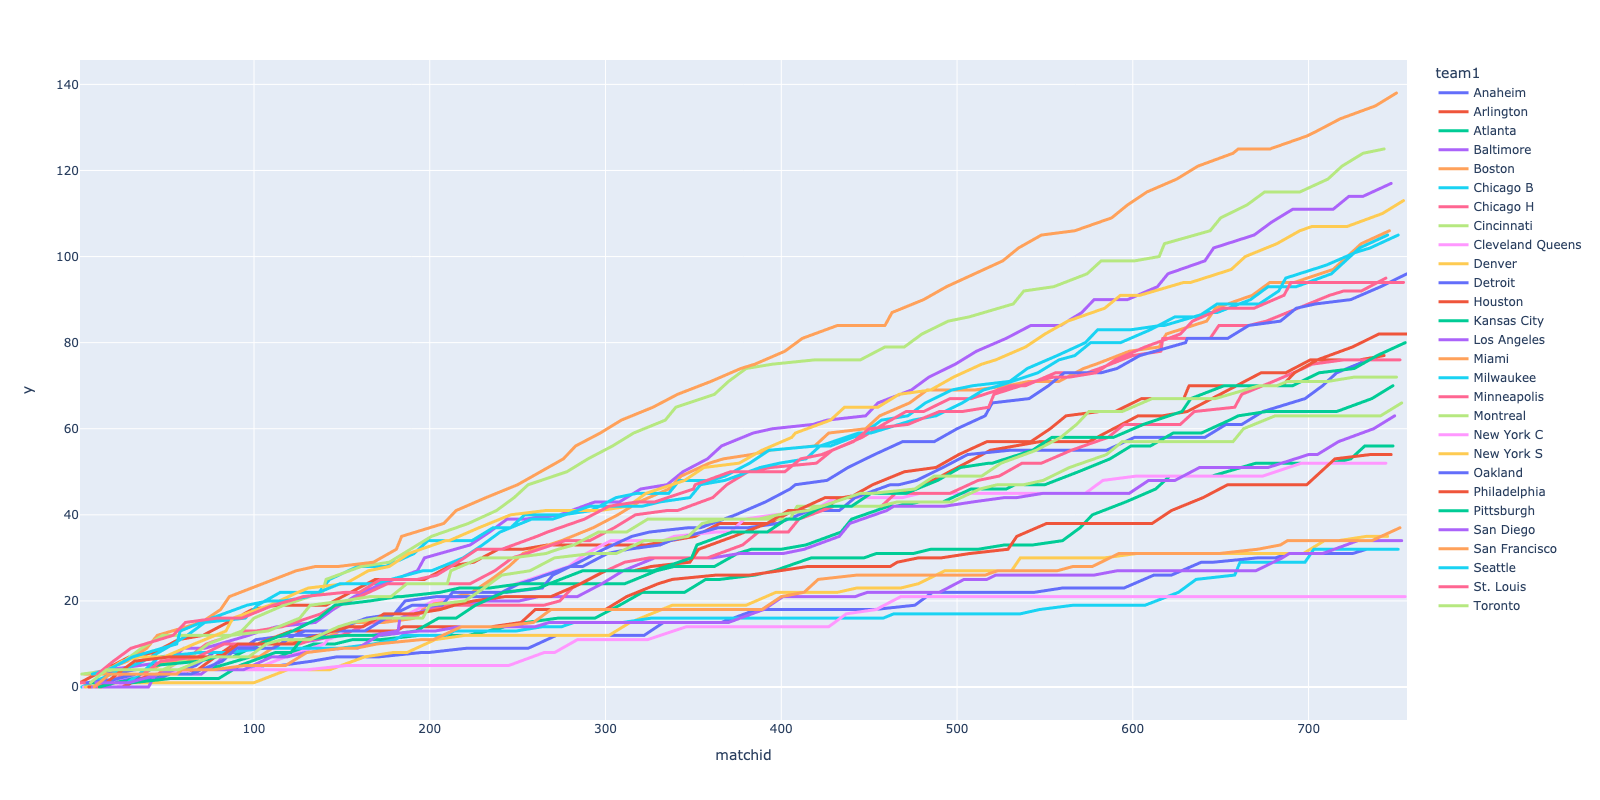

In [240]:
(
    df_s1
    .plot.line(
    x= "matchid", y= df.cum_sum,
    color = "team1",
    width=1600, height=800
    )  
    .update_traces(line= {"width": 3})    
).show("png")


* we see that the number of shots have a positive colleration with number of goals scores and the team who has the most number of shots is the one who won the league. it is an important variable

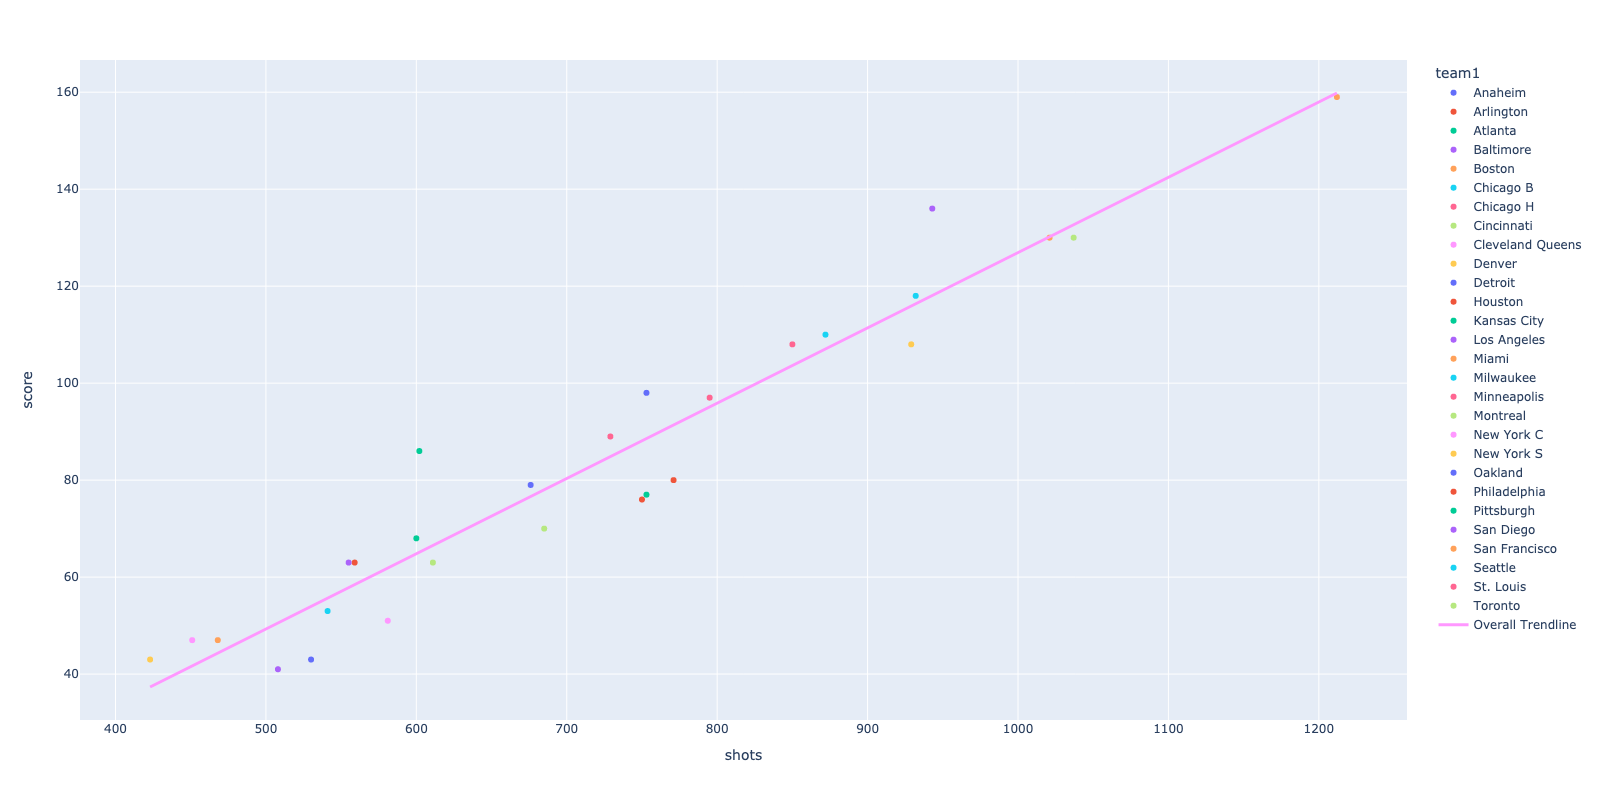

In [241]:
(
    df_s1
    .groupby("team1", as_index=False)
    .agg(
    shots= ("shots", "sum"),
    score= ("score", "sum"),
    )
    .plot.scatter(
    x= "shots", y= "score",
    trendline= "ols", 
    trendline_scope="overall", 
    color = "team1",
    width=1600, height=800
    )  
    .update_traces(line= {"width": 3})    
).show("png")

* Also we notice that teams score more goals consistantly when playing at home because of home advantage and playing at home or away is an important variable to number of goals scored.

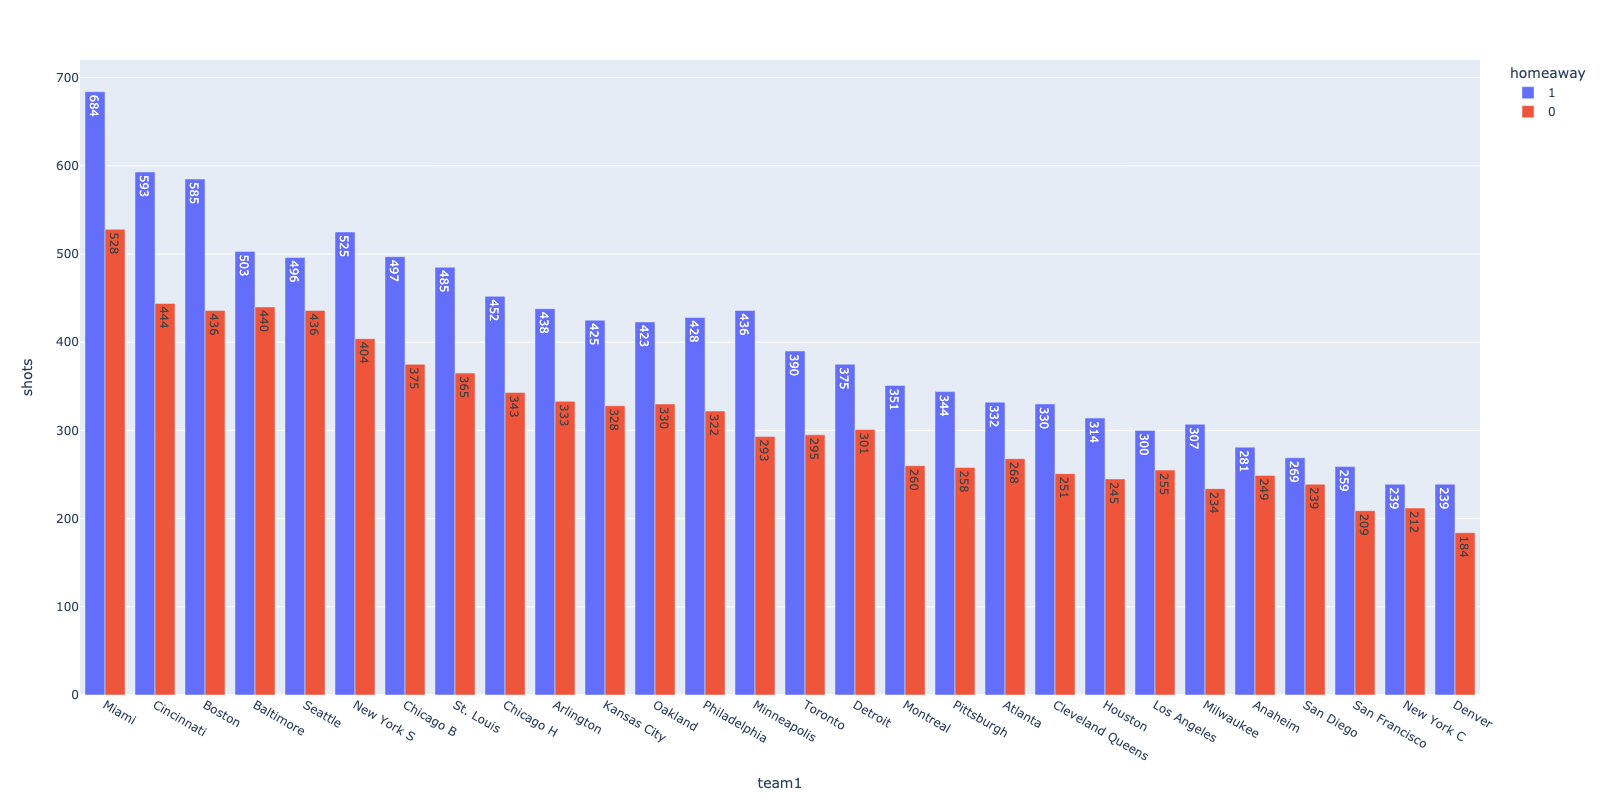

In [242]:
(
    df_s1
     .groupby(["homeaway","team1"], as_index=False)
     .agg(
     shots= ("shots", "sum"),
     score= ("score", "sum"),
     )    
    .sort_values(["score" ,"shots"], ascending= False)
    .assign(homeaway = lambda df_: df_.homeaway.astype("category"))        
    .plot.bar(
    x= "team1", y= "shots",
    barmode='group', 
    color= "homeaway",    
    width=1600, height=800,
    text_auto = True
    ).update_layout(barmode='group', xaxis={'categoryorder':'total descending'})      
).show("png")

* Graph below shows the total score for all teams for season 1, Miami finished number one and Cincinnati finished at 2nd place.

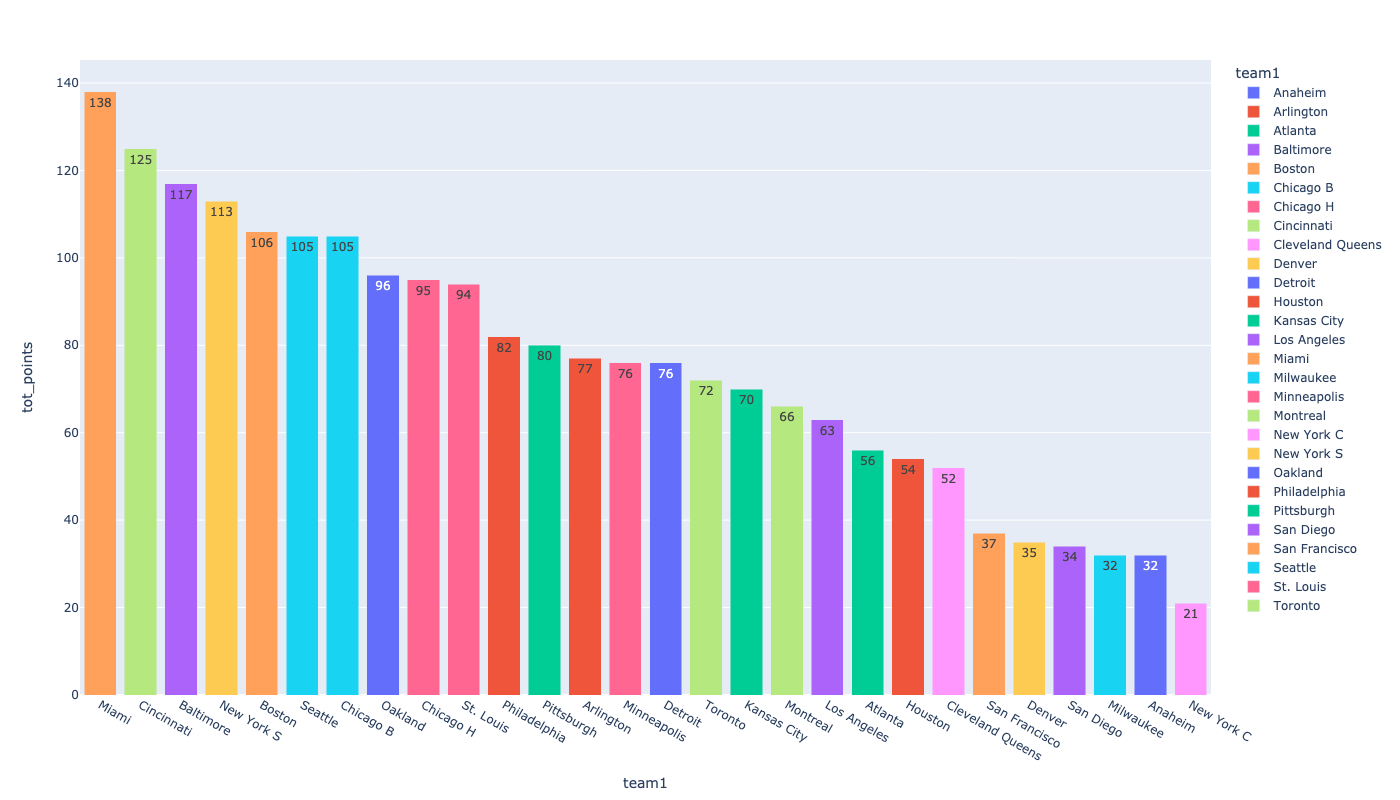

In [243]:
(
    df_s1
    .groupby(["team1"])
    .agg(tot_points = pd.NamedAgg("results", "sum"))
    .reset_index()                
    .assign(team= lambda df_: df_.team1.astype('category') )           
    .plot.bar(
    x= "team1", y="tot_points", 
    orientation='v', 
    color = "team1",
    width=1400, height=800,
    text_auto = True   
    ).update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
).show("png")



* Top 3 team3

In [244]:
top_5= df_s1.groupby(["team1"]).agg('sum', numeric_only=True).sort_values("results", ascending= False).reset_index().head(3)[["team1"]]
top_5

,team1
0,Miami
1,Cincinnati
2,Baltimore


* Bottom 3 teams

In [245]:
bottom_5= df_s1.groupby(["team1"]).agg('sum', numeric_only=True).sort_values("results", ascending= False).reset_index().tail(3)[["team1"]]
bottom_5

,team1
25,Milwaukee
26,Anaheim
27,New York C


In [246]:
top_5.team1

0    Miami     
1    Cincinnati
2    Baltimore 
Name: team1, dtype: object

* Biggest upset of the season 1 is top 1 team Miami losing to New York which is at the bottom of the league Table.m

In [247]:
(
    df_s1
    .query("team1 == @top_5.team1.iloc[0] & team2 == @bottom_5.team1.iloc[0] ")    
    .iloc[0:1,]
    [["team1", "team2", "goal_margin", "homeaway","target"]]
)

,team1,team2,goal_margin,homeaway,target
757,Miami,Milwaukee,-2,0,away_win


* At match number 48 in the season it was clear that the Miami has won the league as the gap between Miami and Cincinnati was 20 and max points to gain for Cincinnati were 18
* as it can be seen by the graph below

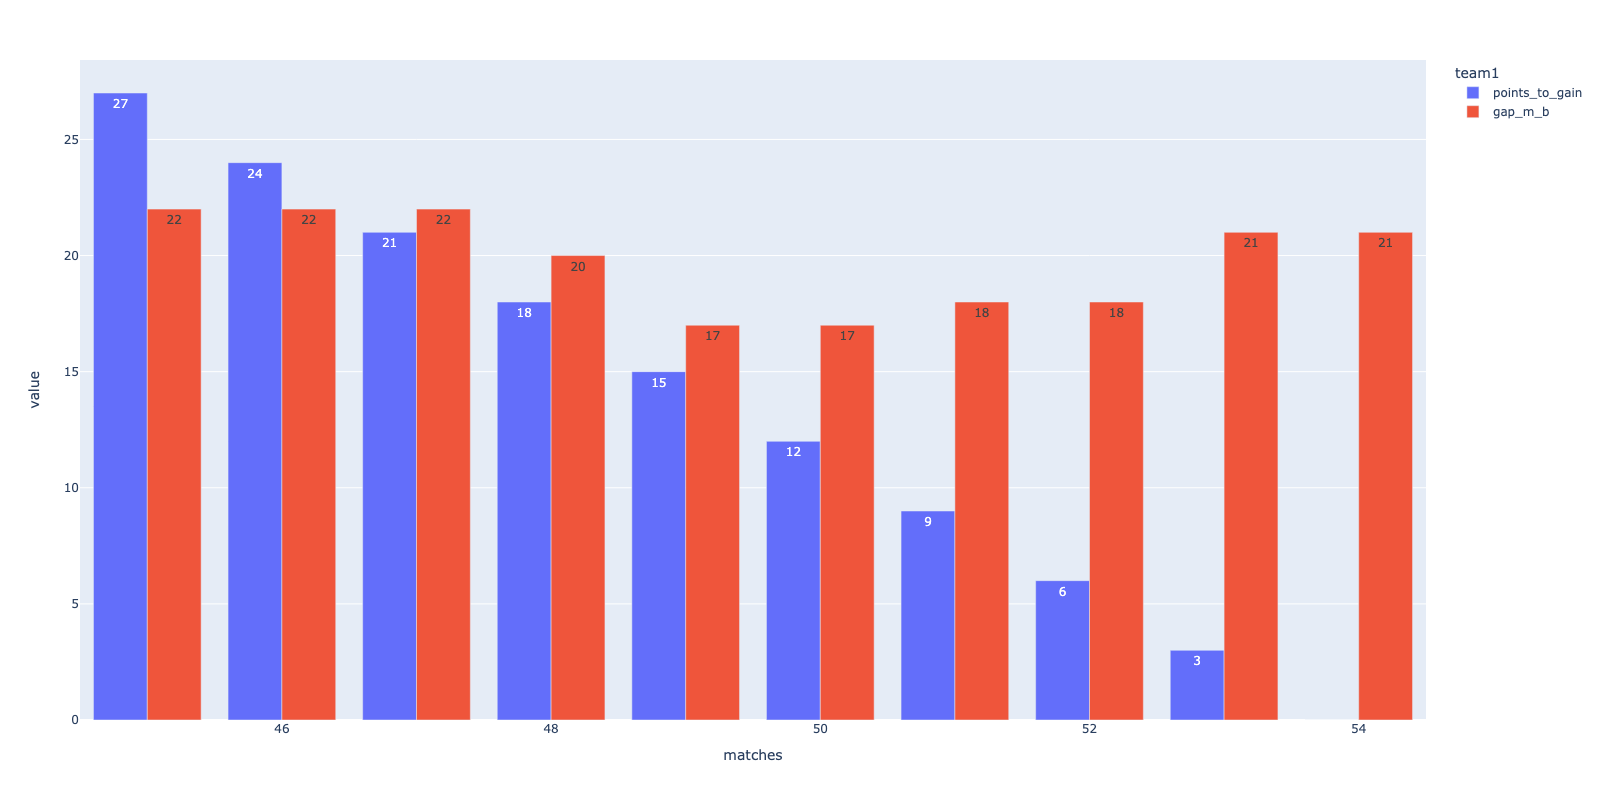

In [248]:
(
df_s1
.assign(
    dif = df["teamid"].shift(1),        
    ) 
 .assign(
     next_team = lambda df_: df_.dif- df_.teamid,
     cum_sum_flag = lambda df_: np.where( df_.next_team == 0 , 1, 0 ),
     matches= lambda df_:  df_.groupby(["teamid"]).agg(cumsum = ("cum_sum_flag", "cumsum"))  +1,          
     matches_left= lambda df_:  54 - df_.matches,
     points_to_gain = lambda df_: df_.matches_left *3
     
     )
  .query('team1.isin(["Miami","Cincinnati","Baltimore"])', engine= "python" ) 
  .groupby(["team1"]).tail(10)
  .filter(["matches","team1", "cum_sum", "matches_left", "points_to_gain"])
  .pivot_table(index= ["matches", "matches_left","points_to_gain" ], columns= ["team1"], values= "cum_sum" ) 
  .reset_index()
  .assign( 
           gap_m_c= lambda df_: df_.Miami - df_.Cincinnati,
           gap_m_b= lambda df_: df_.Miami - df_.Baltimore
           ) 
  .melt(id_vars=["matches"] , value_vars= ["points_to_gain", "gap_m_b"] )    
  .plot.bar(x= "matches", y = "value", color= "team1", barmode='group', width= 1600, height= 800,text_auto = True )
).show("png")

## Feature Engineering

* we connect starting 11 palyers for each match and thr positions they play in the match for using df_players and df_starting data.
* We create a 3 variables:
    * ratio between number of forwards and midfielders
    * ratio between number of forwards and defenders
    * ratio between number of midfielders and defenders

In [249]:
df_pl=(
    df_startingXI    
    .melt(id_vars=["matchid"])
    .drop(columns="variable")
      .merge(
      df_players    
      , how="left", left_on="value", right_on=  "playername")
       .drop(columns="value")
       .assign(roles= lambda df_: np.where(df_.positionid == 1, "goalkeeper", 
                                           np.where(df_.positionid == 2, "defender",
                                                    np.where(df_.positionid == 3, "midfielder", "forward" 
                                                    ))                                                             
                                            )   )
       .groupby(["matchid", "teamid", "roles"], as_index=False)
       .agg(playing= ("roles", "count"))
       .pivot_table(index= ["matchid","teamid"], columns= ["roles"], values= "playing" )
       .reset_index()
       .assign(
    ratio_fm = lambda df_: df_.forward/ df_.midfielder,
    ratio_fd = lambda df_: df_.forward/ df_.defender,
    ratio_md = lambda df_: df_.midfielder/ df_.defender   
                )   
    .drop(columns= ['defender', 'forward', 'goalkeeper', 'midfielder'])
    )
df_pl.tail()

roles,matchid,teamid,ratio_fm,ratio_fd,ratio_md
3275,1510,17,0.4,0.666667,1.666667
3276,1511,13,1.0,0.750000,0.750000
3277,1511,16,1.0,0.750000,0.750000
3278,1512,14,1.0,0.750000,0.750000
3279,1512,15,0.4,0.666667,1.666667


* we calcuate home and away team shot and score rate on season 1 and attach these features with our test and train data set.
* we also add odds information as variable to our data.
* wee combine all the created variables above to our data and remove the columns: 

"seasonid","matchid","homeshots","awayshots", "homescore","awayscore", "home_win_points", "away_win_points", "goal_margin",  "gameweek"

In [250]:
def feature_engineer(x):
    stat_hometeam=(
        df_ml[x]
        .groupby(["hometeamid"],as_index=False).agg(
        h_shot_rate= ("homeshots", "mean"),
        h_score_rate= ("homescore", "mean"),        
        h_shots_min= ("homeshots", "min")
        )
        .assign(shot_goal_h= lambda df_: df_.h_score_rate/ df_.h_shot_rate)
    )
    stat_awayteam=(
        df_ml[x]
        .groupby(["awayteamid"],as_index=False).agg(
        a_shot_rate= ("awayshots", "mean"),
        a_score_rate= ("awayscore", "mean"),        
        a_shots_min= ("awayshots", "min")
        )
        .assign(shot_goal_a= lambda df_: df_.a_score_rate/ df_.a_shot_rate)
    )
    df1=(
        df_ml[x]
        .merge(stat_hometeam, how="left", on= "hometeamid")
        .merge(stat_awayteam, how="left",on= "awayteamid")         
    )
    df =(
        df1    
        .merge(
        df_odds,
        how= "left",
        on = "matchid"    
    )
    .merge(df_pl, how="left", left_on = ["matchid", "hometeamid"], right_on = ["matchid", "teamid"])
    .assign(
        hometeamid= lambda df_: df_.hometeamid.astype("object"),
        awayteamid= lambda df_: df_.awayteamid.astype("object"),
    )    
    .merge(df_pl, how="left", left_on = ["matchid", "awayteamid"], right_on = ["matchid", "teamid"])
    )    
    cols_to_drop = ["teamid_x","teamid_y","seasonid","matchid","homeshots","awayshots", "homescore","awayscore", "home_win_points", "away_win_points", "goal_margin", 
                    #"goalkeeper_x",
                      "gameweek",
                      "h_shot_rate",
                      "a_shot_rate"
                    ]
    df=df.drop(columns=cols_to_drop)    
    
    return df

In [251]:
df_train_test= {key:feature_engineer(key) for key in df_seasons.keys()}
df_train= df_train_test["s1"]
df_test= df_train_test["s2"]

* There are no empty Values in our test and train data set

In [252]:
df_test.isna().sum().to_frame().T

,hometeamid,awayteamid,target,h_score_rate,h_shots_min,shot_goal_h,a_score_rate,a_shots_min,shot_goal_a,home,draw,away,ratio_fm_x,ratio_fd_x,ratio_md_x,ratio_fm_y,ratio_fd_y,ratio_md_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [253]:
df_train.isna().sum().to_frame().T

,hometeamid,awayteamid,target,h_score_rate,h_shots_min,shot_goal_h,a_score_rate,a_shots_min,shot_goal_a,home,draw,away,ratio_fm_x,ratio_fd_x,ratio_md_x,ratio_fm_y,ratio_fd_y,ratio_md_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


* correlation graph below shows, that shot rate and score rate show high correlation as expected as well as the odds variable.
* the ratio that we created between number of midfielder, forwards and attacker has low correlation but we will keep all these variables

<AxesSubplot: >

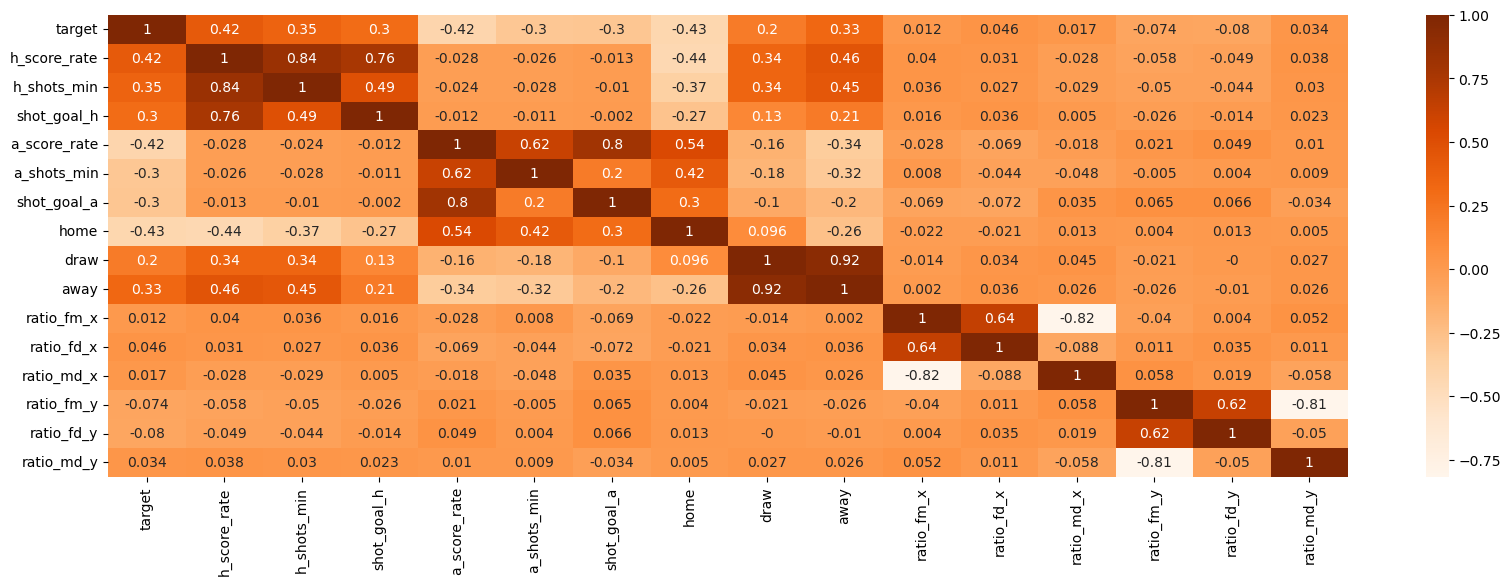

In [254]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_cor= df_train.copy()
df_cor["target"]= encoder.fit_transform(df_cor["target"])
df_cor= df_cor.corr( numeric_only= True).round(3)
plt.figure(figsize=(20, 6))
sns.heatmap(df_cor, cmap= "Oranges" , annot=True, annot_kws={"fontsize":10})

### Preprocess and prepare Data for model training

In [255]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train= encoder.fit_transform(df_train["target"])
X_train=df_train.drop(columns= "target")
y_test= encoder.fit_transform(df_test["target"])
X_test=df_test.drop(columns= "target")
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((756, 17), (756,), (756, 17), (756,))

* 0 is away_win, 1 is draw and 2 is home_win

In [256]:
for index, label in enumerate(encoder.classes_):
    print(f"{label} -> {index}")

away_win -> 0
draw -> 1
home_win -> 2


### Define Column Types

In [257]:
num_cols= X_train.select_dtypes([float, int]).columns
cat_cols= X_train.columns[~X_train.columns.isin(num_cols)]
num_cols,cat_cols

(Index(['h_score_rate', 'h_shots_min', 'shot_goal_h', 'a_score_rate',
        'a_shots_min', 'shot_goal_a', 'home', 'draw', 'away', 'ratio_fm_x',
        'ratio_fd_x', 'ratio_md_x', 'ratio_fm_y', 'ratio_fd_y', 'ratio_md_y'],
       dtype='object'),
 Index(['hometeamid', 'awayteamid'], dtype='object'))

## Preprocess pipeline

In [258]:
# preprocess
from imblearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
# transformer/imputer/scaller/var filter
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn import  ensemble

### Create Evaluation Matric function

In [259]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
def eval_scores(actuals, pred, proba):
    res= pd.DataFrame({ 
    "accuracy": [accuracy_score(actuals, pred),], 
    "recall": [recall_score(actuals, pred, average='weighted')],
    "roc_auc": [roc_auc_score(actuals, proba,multi_class='ovr')],
    "precision": [precision_score(actuals, pred,average='weighted')]
    })
    return res


### Create pipelines for numeric and categorical data  

In [260]:
num_pipe= Pipeline (
        steps =[
        ("std_scaler", StandardScaler()),               
                ]
                    )
cat_pipe= Pipeline (
        steps =[        
        ("one_hot", OneHotEncoder(sparse_output=False, drop= "first", handle_unknown= "ignore")),        
                ]
                    )

from sklearn.decomposition import PCA
prep = ColumnTransformer(
    transformers= [      
        ("num", num_pipe, num_cols),         
        ("cat", cat_pipe, cat_cols),   
        ],
        remainder="passthrough",        
n_jobs=-1,
).set_output(transform="pandas")

prep.fit_transform(X_train)

,num__h_score_rate,num__h_shots_min,num__shot_goal_h,num__a_score_rate,num__a_shots_min,num__shot_goal_a,num__home,num__draw,num__away,num__ratio_fm_x,num__ratio_fd_x,num__ratio_md_x,num__ratio_fm_y,num__ratio_fd_y,num__ratio_md_y,cat__hometeamid_2,cat__hometeamid_3,cat__hometeamid_4,cat__hometeamid_5,cat__hometeamid_6,cat__hometeamid_7,cat__hometeamid_8,cat__hometeamid_9,cat__hometeamid_10,cat__hometeamid_11,cat__hometeamid_12,cat__hometeamid_13,cat__hometeamid_14,cat__hometeamid_15,cat__hometeamid_16,cat__hometeamid_17,cat__hometeamid_18,cat__hometeamid_19,cat__hometeamid_20,cat__hometeamid_21,cat__hometeamid_22,cat__hometeamid_23,cat__hometeamid_24,cat__hometeamid_25,cat__hometeamid_26,cat__hometeamid_27,cat__hometeamid_28,cat__awayteamid_2,cat__awayteamid_3,cat__awayteamid_4,cat__awayteamid_5,cat__awayteamid_6,cat__awayteamid_7,cat__awayteamid_8,cat__awayteamid_9,cat__awayteamid_10,cat__awayteamid_11,cat__awayteamid_12,cat__awayteamid_13,cat__awayteamid_14,cat__awayteamid_15,cat__awayteamid_16,cat__awayteamid_17,cat__awayteamid_18,cat__awayteamid_19,cat__awayteamid_20,cat__awayteamid_21,cat__awayteamid_22,cat__awayteamid_23,cat__awayteamid_24,cat__awayteamid_25,cat__awayteamid_26,cat__awayteamid_27,cat__awayteamid_28
0,-1.348244,-1.035737,-2.172365,0.013976,1.15845,0.515062,-0.003744,-0.643732,-0.407272,-0.901131,0.234766,1.359997,-0.471098,-1.342322,-0.403044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.794816,0.378928,0.629573,0.013976,1.15845,0.515062,-0.464297,-0.415968,-0.205468,-0.523495,-1.364179,-0.353242,-0.471098,-1.342322,-0.403044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.633890,-0.328404,-0.048707,0.013976,1.15845,0.515062,0.096862,-0.516084,-0.427310,-0.523495,-1.364179,-0.353242,1.458209,1.091240,-1.044519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.465115,0.025262,-0.076101,0.013976,1.15845,0.515062,-0.535839,0.047068,-0.021554,1.364684,1.034238,-0.995707,1.458209,1.091240,-1.044519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.128443,-1.743069,-0.573899,0.013976,1.15845,0.515062,0.014142,-0.531101,-0.420154,-0.901131,0.234766,1.359997,1.458209,1.091240,-1.044519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,-1.403194,-1.035737,-1.631938,-0.377341,1.15845,-0.865693,0.544001,-0.228250,-0.454503,-0.901131,0.234766,1.359997,-0.856959,0.280053,1.307558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,-1.073493,-0.682070,-0.777773,-0.377341,1.15845,-0.865693,0.597658,-0.295829,-0.453788,-0.901131,0.234766,1.359997,-0.471098,-1.342322,-0.403044,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Models Random Forest

### Create complete preprocess + model pipes

In [261]:
MLA= {       
    "rf": ensemble.RandomForestClassifier(class_weight= "balanced",n_jobs= -1, random_state=1 ),    
    }  
pipes = {}
for x in MLA.keys():    
        pipe= Pipeline(steps=[
                ("preprocess", prep),
                ("model", MLA[x])]
                ).set_output(transform="pandas")
        pipes[x]=  pipe
pipes.keys()

dict_keys(['rf'])

### Initial Run without hyper parameters

In [262]:

cl_report= []
scores= []
auc_scores =[]
for model in MLA.keys():    
    pipes[model].fit(X_train, y_train )     
    scores.append( eval_scores(y_test, pipes[model].predict(X_test), pipes[model].predict_proba(X_test) ).assign(model = model))   
    print(pipes[model].score(X_train, y_train ))

pd.concat(scores).sort_values("accuracy", ascending=False)

1.0


,accuracy,recall,roc_auc,precision,model
0,0.592593,0.592593,0.702684,0.548599,rf


* Accuracy score is 1 as model is overfitting,
* precision on testing data is pretty low and accuracy is .59 and model is not picking up draws very well
* draws are always hard to predict but we will see if we can improve it with hyperparameters tunning as we can see model is severely overfitting as well.

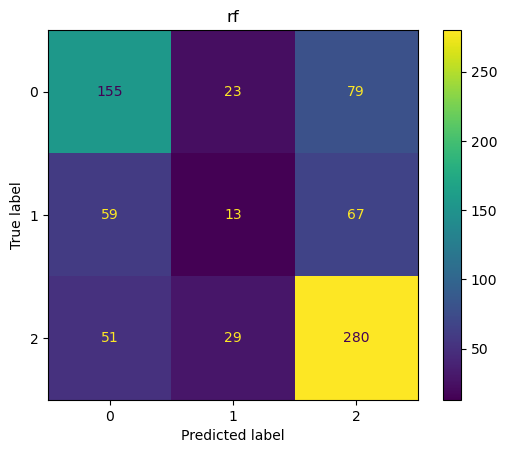

In [263]:
for x in MLA.keys():    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(y_test,pipes[x].predict(X_test), labels=pipes[x]["model"].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pipes[x]["model"].classes_)
    disp.plot()
    plt.title(x)
    plt.show()

### CV split

In [264]:
from sklearn.model_selection import StratifiedKFold
cv_split = StratifiedKFold(n_splits= 10, random_state=10 , shuffle=True)

### BayesianGrid Search 

In [265]:
from skopt.space import Integer

grid_n_estimator =  np.arange(50, 1500, 10) 
max_features = ['sqrt']
grid_max_depth = Integer(4,6) 
grid_sample_split= Integer(60,150)
grid_min_sample_leaves = Integer(55, 60)


MLA_params = {                        
    "rf" : [{                        
        'model__n_estimators': grid_n_estimator,  
        'model__max_depth': grid_max_depth,         
        'model__max_features': max_features,        
        'model__min_samples_leaf': grid_min_sample_leaves,
        'model__min_samples_split': grid_sample_split
            }]            
    } 

* F1-micro and F1-macro are metrics for evaluating the performance of multi-class classification models. They are based on the concept of precision and recall, which are measures of how well the model is able to correctly identify true positive cases and avoid false positives.

* F1-micro is calculated by considering all the instances in the data set as a single pool, and calculating the precision and recall for the entire pool. This means that each instance is given the same weight, regardless of which class it belongs to. 

* The F1-micro score is the harmonic mean of precision and recall. 

* F1-macro, on the other hand, is calculated by considering each class separately and calculating the precision and recall for each class. The F1-macro score is the average of the F1 scores for each class.

* We use F1-micro as a our metric

In [266]:
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings("ignore", category= Warning)
warnings.filterwarnings("ignore", category= UserWarning)

tune_params = {}
best_model_scores= {}
best_models = {}
scores =[]

for x in MLA.keys():
    # log-uniform: understand as search over p = exp(x) by varying x
    opt = BayesSearchCV(
        estimator= pipes[x],
        search_spaces= MLA_params[x],            
        n_iter= 50,
        cv= cv_split,
        scoring= "f1_micro",
        optimizer_kwargs={'base_estimator': 'gp'},        
        verbose=0,
        n_points= 50,        
        random_state= 421,
        n_jobs= -1
    )
    opt.fit(X_train, y_train)
    print(f"val. score: {opt.best_score_}  model:{x} "  )
    print(f"test score: {opt.score(X_test, y_test)}  model:{x}"  )
    best_model_scores[x] = [opt.best_score_]    
    best_model= pipes[x].set_params(**dict(opt.best_params_)).fit(X_train, y_train)        
    best_models[x] =  best_model            
    scores.append(eval_scores(y_test,best_model.predict(X_test), best_model.predict_proba(X_test)).assign(model=x))


val. score: 0.6057719298245614  model:rf 
test score: 0.5740740740740741  model:rf


### Evaluation Scores
We use fi-micro matric for evaluation of multiclass score.
the fi_training score is .605 and on testing its .572 with ROC_AUC score of .715, over 10kfold on training data.
Precision of the model has improved from .54 to .599 and we see from the graph below model is not overfitting.

In [267]:
pd.DataFrame.from_dict(best_model_scores)

,rf
0,0.605772


In [268]:
pd.concat(scores)

,accuracy,recall,roc_auc,precision,model
0,0.574074,0.574074,0.72071,0.593649,rf


### Cross Validation

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt

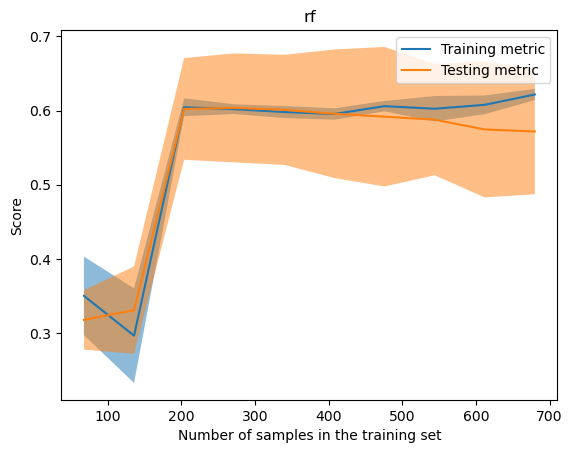

In [286]:
from sklearn.model_selection import LearningCurveDisplay
for x in MLA.keys():           
    _= LearningCurveDisplay.from_estimator(
    best_models[x], X_train, y_train, cv=10, n_jobs=-1, score_type= "both", train_sizes= np.linspace(0.1, 1, 10 )
    )   
    plt.title(x)

## Best Model

In [270]:
test_model_variable= "rf"

In [271]:
final_pipe= best_models[test_model_variable]
final_pipe = final_pipe.fit(X_train, y_train)
final_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  Index(['h_score_rate', 'h_shots_min', 'shot_goal_h', 'a_score_rate',
       'a_shots_min', 'shot_goal_a', 'home', 'draw', 'away', 'ratio_fm_x',
       'ratio_fd_x', 'ratio_md_x', 'ratio_fm_y', 'ratio_fd_y', 'ratio_md_y'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['hometeamid', 'awayteamid'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        min_samples_leaf=60,
                                        min_samples_split=61, n_estimators=70,
                                        n_jobs=-1, random_state=1))])

* We see from the confusio nmatrix below that the model is picking a little more of the draws correctly but still performance is lowest for correctly picking up draws.

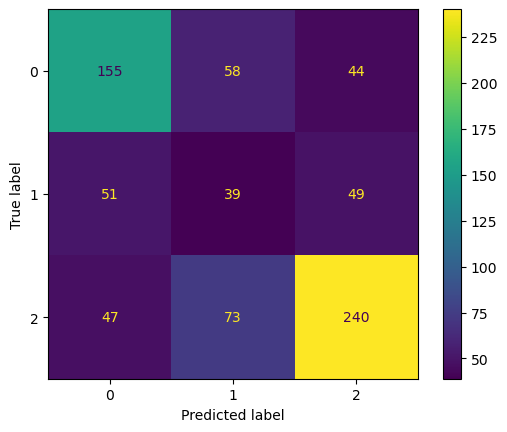

In [272]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,final_pipe.predict(X_test), labels=final_pipe["model"].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=final_pipe["model"].classes_)
disp.plot()
plt.show()

### Lets look at the roc_auc curve. 
Since its a classification problem we will create auc_roc curve seperately for erach class, taking each class as positive and rest of the classes as negative.

In [273]:
y_pred_prob= final_pipe.predict_proba(X_test)
# calculate AUC-ROC values for each class
auc_scores = []
for i in range(3):
    auc_scores.append(
        roc_auc_score(y_test == i, y_pred_prob[:, i])
                      )
df_auc = pd.DataFrame(columns=[f"Class{i}" for i in range(3)] + ['Avg_auc_roc'])
df_auc.loc[0] = auc_scores + [np.mean(auc_scores)]
df_auc=df_auc.round(2)

* The Graph below shows indiavidual roc_auc values and we see for class 0, its .79, for class 2 its .79 and for class 1 its .59 and is the lowest
* Avg roc_auc is .72
* the area under the curve is the smallest for class 0

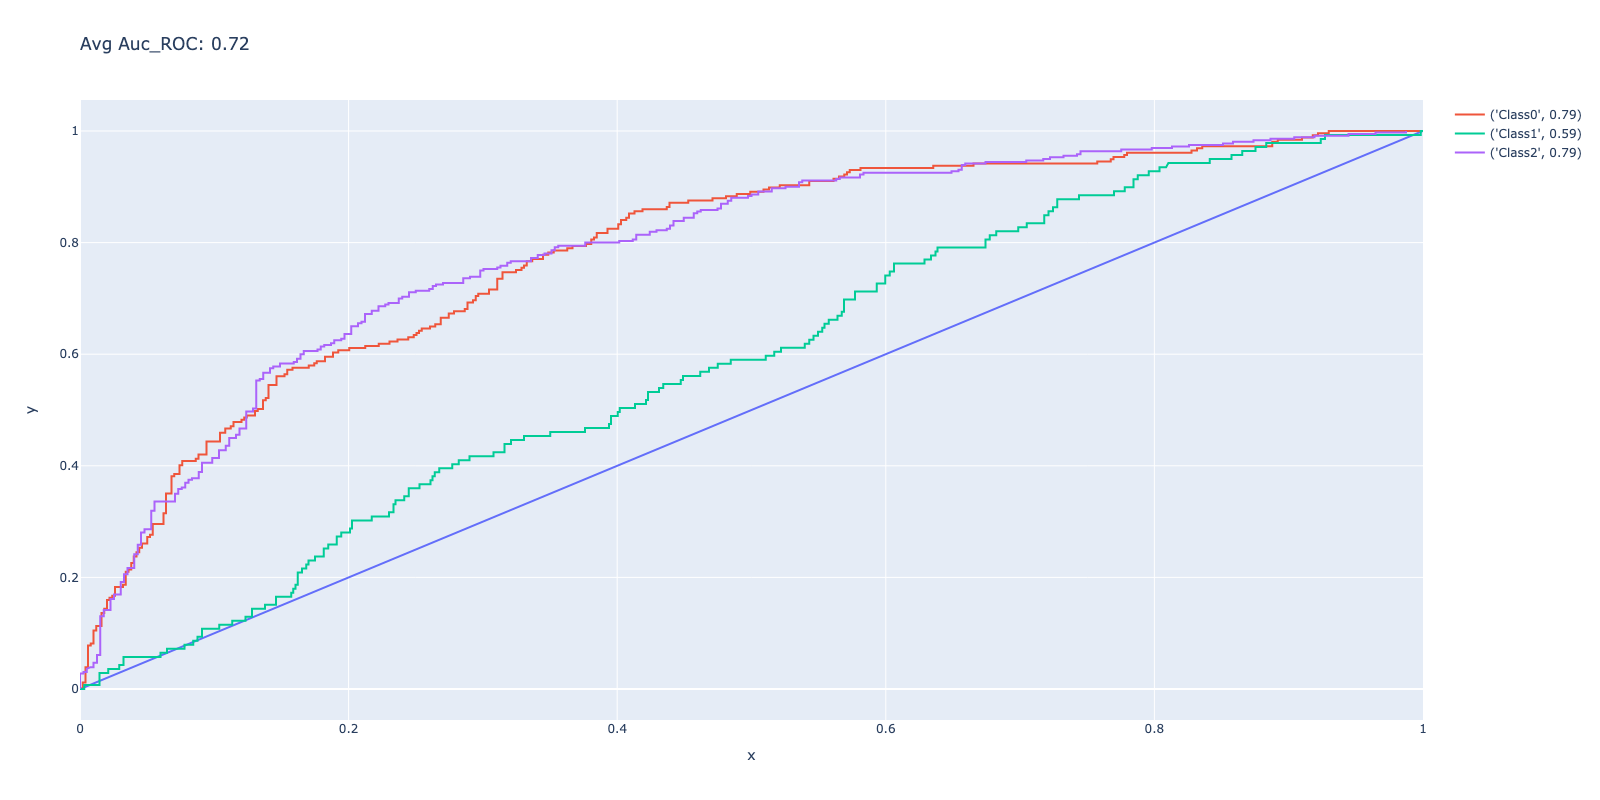

In [274]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
df_auc_roc= pd.DataFrame()
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_prob[:, i])    
    df_auc_roc["fpr"+str(i)]=  pd.Series(fpr)
    df_auc_roc["tpr"+str(i)]= pd.Series(tpr)
    
(
    df_auc_roc
    .plot.line(x=[0,1], y= [0,1], width= 1600, height=800, title = f"Avg Auc_ROC: {df_auc.Avg_auc_roc[0]}")
    .add_scatter(x=df_auc_roc.fpr0,y=df_auc_roc.tpr0, name=f"{df_auc.Class0.name , df_auc.Class0[0]}")    
    .add_scatter(x=df_auc_roc.fpr1,y=df_auc_roc.tpr1, name=f"{df_auc.Class1.name , df_auc.Class1[0]}")    
    .add_scatter(x=df_auc_roc.fpr2,y=df_auc_roc.tpr2, name=f"{df_auc.Class2.name , df_auc.Class2[0]}")        
).show("png")

## Lets Comapre our prediction results to the original data of season 2

In [275]:
plot_s2=(  
    df_s2    
    .groupby(["team1"])
    .agg(tot_points = pd.NamedAgg("results", "sum"))
    .reset_index()                
    .assign(team= lambda df_: df_.team1.astype('category') )           
    .plot.bar(
    x= "team1", y="tot_points", 
    orientation='v', 
    color = "team1",
    width=1400, height=800,
    text_auto = True,
    title = "<b> Top 5 teams according to original data</b>"
    ).update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
)

In [276]:
df_predictions= (
    df_ml["s2"]
    .assign(
    predictions= encoder.inverse_transform(final_pipe.predict(X_test))
    )    
    .drop(columns= ["target",'goal_margin',   'home_win_points', 'away_win_points'])
    .rename(columns= {"predictions": "target"})
    .assign( 
    home_win_points = lambda df_ : np.where ( df_.target.isin(["home_win"]), 3,
                                                np.where(df_.target.isin(["away_win"]), 0, 1
                                                                            ) ),
    away_win_points = lambda df_ : np.where (df_.target.isin(["away_win"]), 3,
                                            np.where(df_.target.isin(["home_win"]), 0, 1 
                                                                            )) 
    ).pipe(eda_season_data)                                                                        
    ).copy()

In [277]:
df_final_pred=  (
    df_predictions
    .sort_values(["team1","matchid"])
    .reset_index(drop=True)
    .assign(
        cum_sum = 
        df_predictions
        .sort_values(["team1","matchid"])
        .reset_index()
        .groupby("team1")
        .agg(cum_sum = ("results", "cumsum"))                                                             
                        )
    )                                                                                                               

* The actual values show that top 5 teams are Miami, New york S, Baltimore , Boston and Cincinnati.

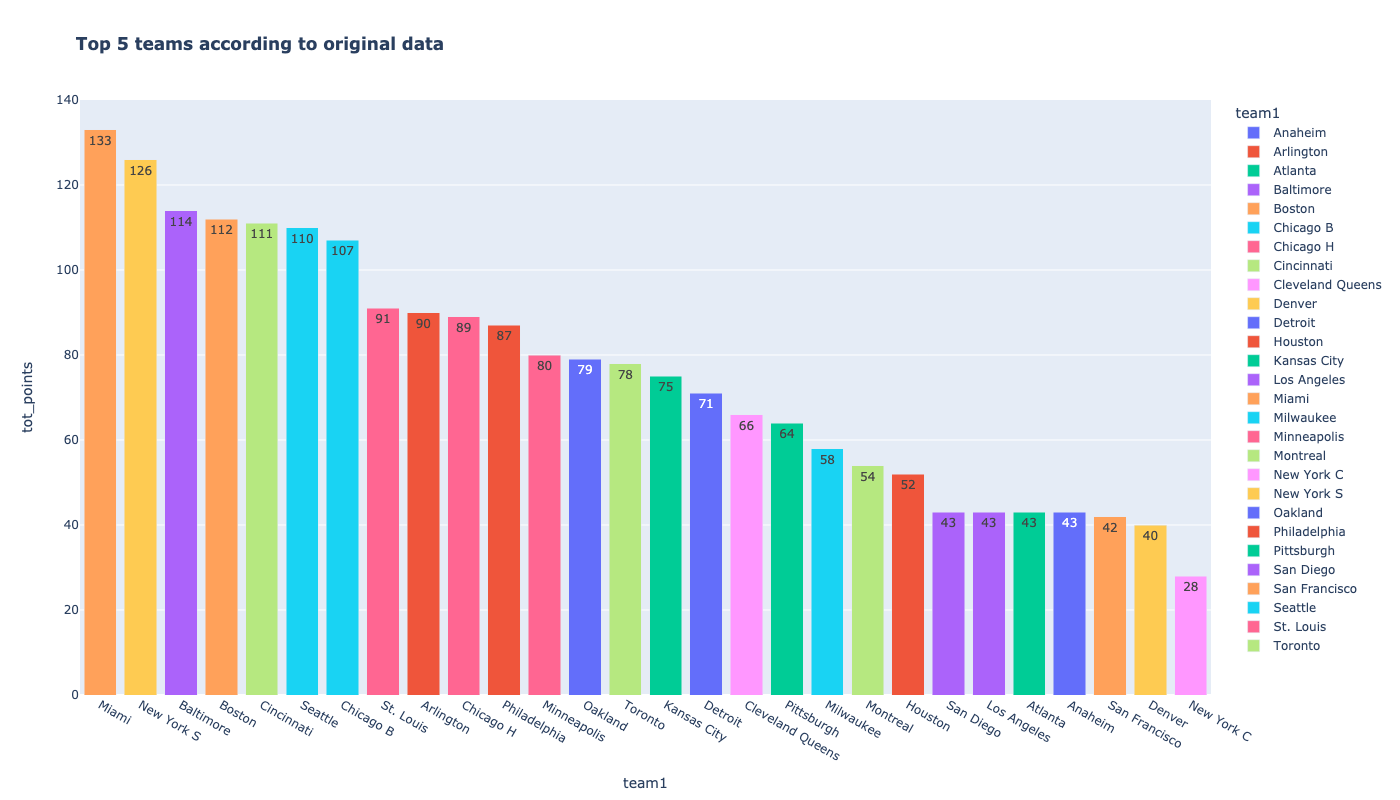

In [278]:
plot_s2.show("png")

* According to our Predictions, the top 5 teams are Boston, New york S, Miami, Chicago B, and Cincinnati.
* we did manage to get 4 out of 5 team right in top 5 but not in the same order of course.

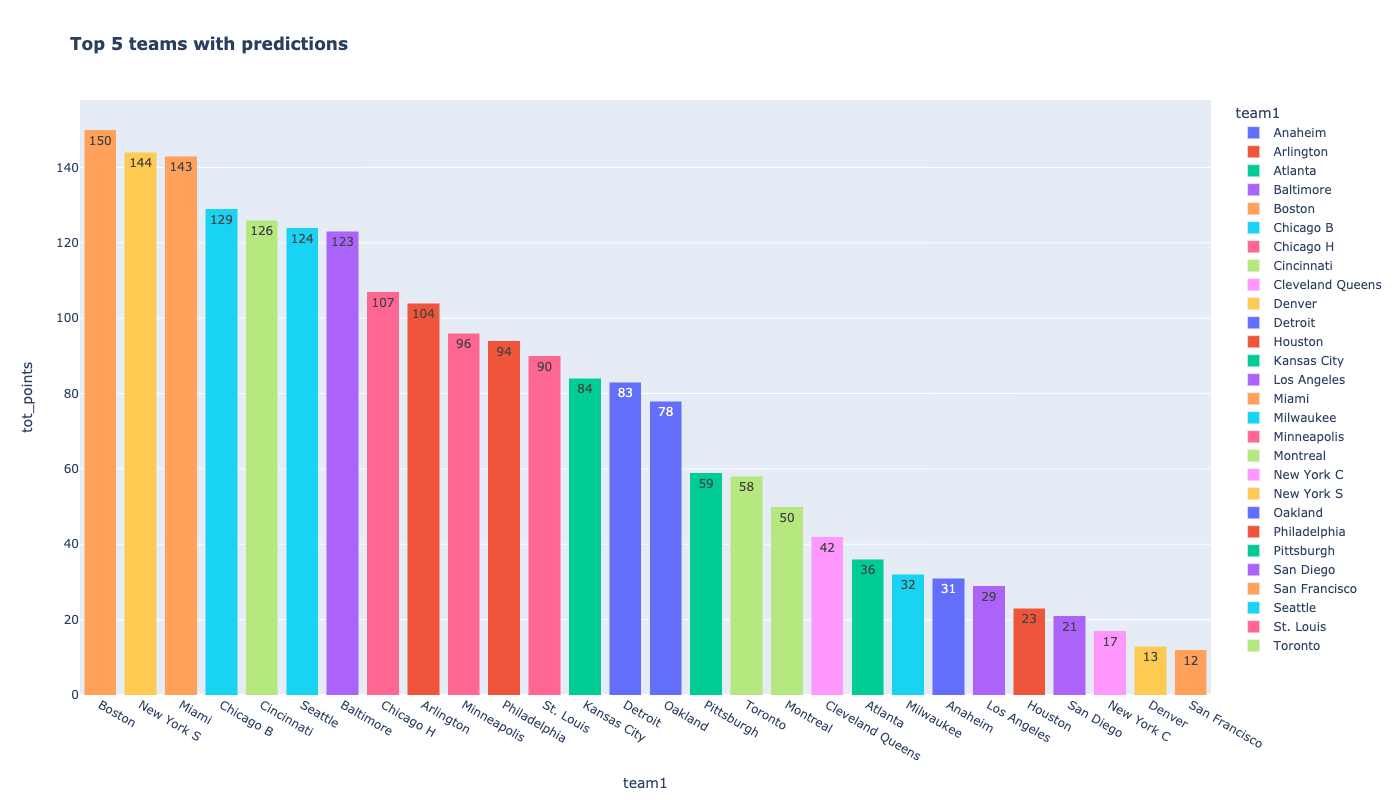

In [279]:
plot_predictions=(   df_final_pred   
    .groupby(["team1"])
    .agg(tot_points = pd.NamedAgg("results", "sum"))
    .reset_index()                
    .assign(team= lambda df_: df_.team1.astype('category') )           
    .plot.bar(
    x= "team1", y="tot_points", 
    orientation='v', 
    color = "team1",
    width=1400, height=800,
    text_auto = True,
    title = "<b>Top 5 teams with predictions</b>"
    ).update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
)
plot_predictions.show("png")

In [280]:
df_predictions=(    
    df_ml["s2"][["target"]]
    .assign(
    predictions= encoder.inverse_transform(final_pipe.predict(X_test)),
    prob0= y_pred_prob[:,0],
    prob1= y_pred_prob[:,1],
    prob2= y_pred_prob[:,2]
    )               
)

### Lets see if we use this model for betting how much success we couldve gotten
* Lets select a probability threshold of .5 and see the results.
* if we set prob threshold above .50 we predicted 27 away wins correctly and 7 incorrectly.

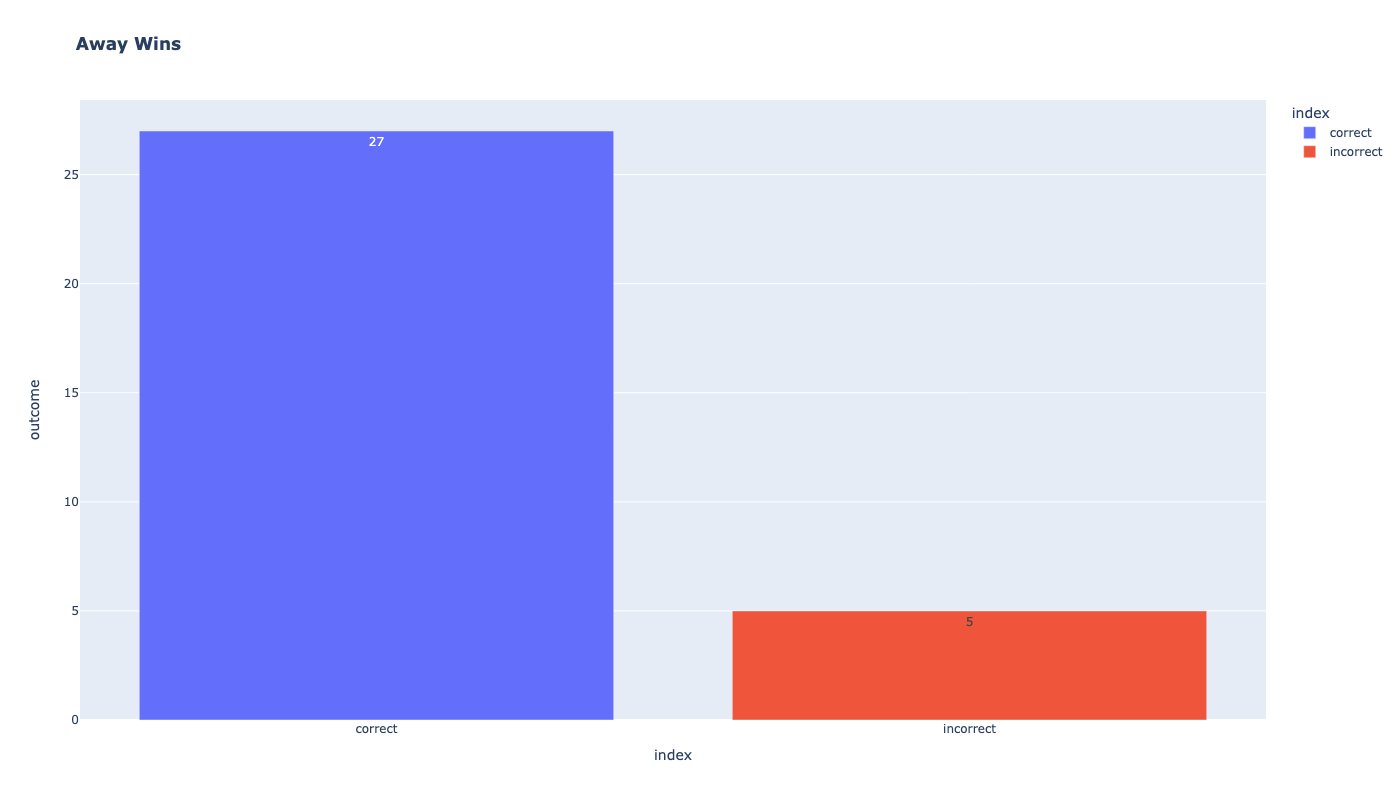

In [281]:
(
    df_predictions.query( 'prob0 >.50')
    .assign( 
    outcome= lambda df_: np.where(df_.predictions== df_.target, "correct", "incorrect" )    
    )
    .outcome
    .value_counts()
    .reset_index()
    .plot.bar(x="index", y= "outcome", color= "index",text_auto=True, title= "<b> Away Wins </b>",width=1400, height=800)
    .show("png")
)

* if we set prob threshold above .50 we predicted 58 home wins correctly and 10 incorrectly.

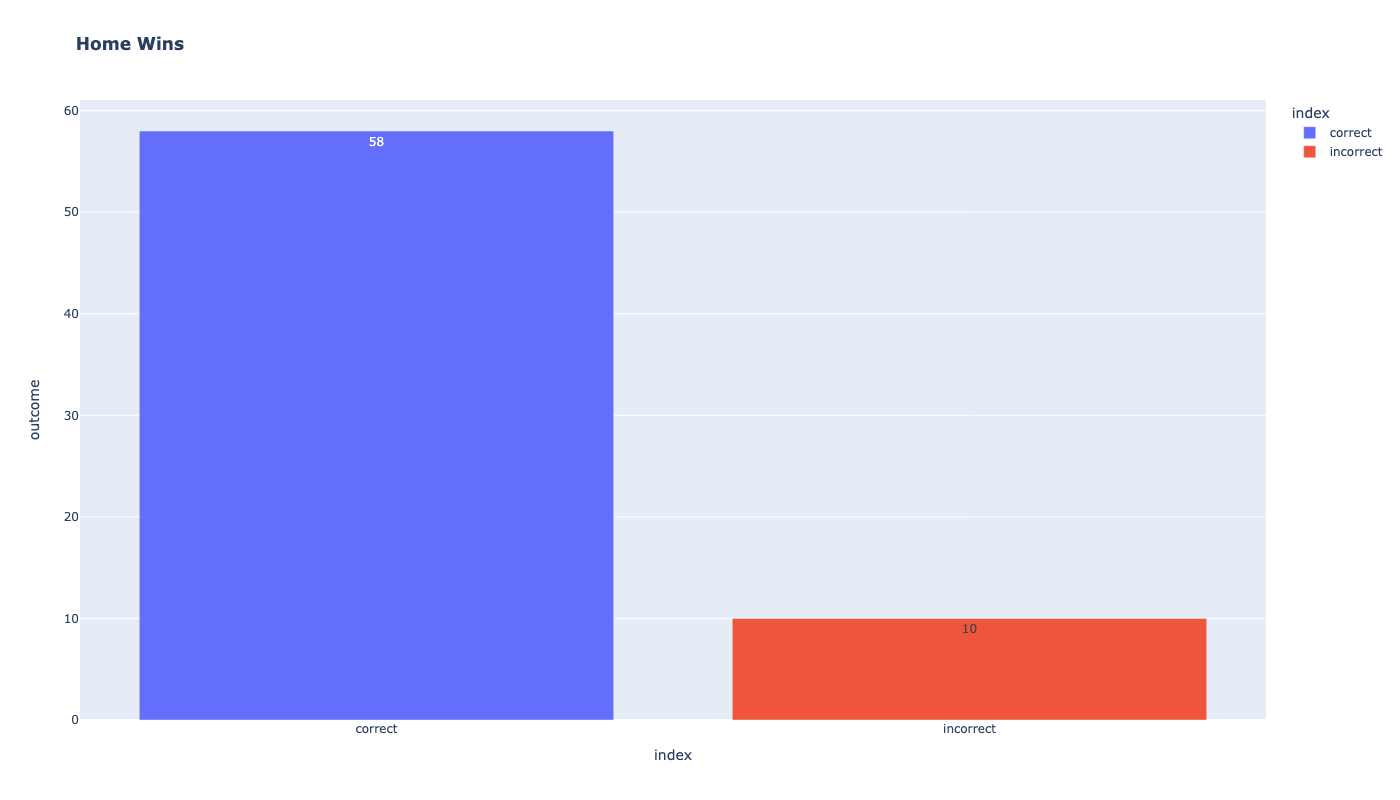

In [282]:
(
    df_predictions.query( 'prob2 >.5')
    .assign( 
    outcome= lambda df_: np.where(df_.predictions== df_.target, "correct", "incorrect" )    
    )
    .outcome
    .value_counts()
    .reset_index()
    .plot.bar(x="index", y= "outcome", color= "index",text_auto=True, title= "<b> Home Wins </b>",width=1400, height=800,)
    .show("png")
)

# Conclusion:
* The data was successfully analyzed to create a model for predicting the outcome of football matches.
* Additionally, the EDA allowed for several insights, such as the importance of the number of shots variable in predicting the outcome of football matches.
* It was also found that teams score more goals when playing at home, highlighting the advantage of playing in familiar surroundings.
* The resulting model can be used to predict future match outcomes only for predictions with high probablity threshold for home or away wins. 
* However to improve the model, we probably need a lot more information , like player stats, rankings, ratings, injuries teamwork etc. many more variables can be added to strenghten the model.
* Additionally, the insights gained from the EDA can be used to help teams make informed decisions about how to approach future matches.